In [7]:
from app.arc2face import FaceReconstructor

reconstructor = FaceReconstructor(root_dir="..", models_dir="../models", device="cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/arcface.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


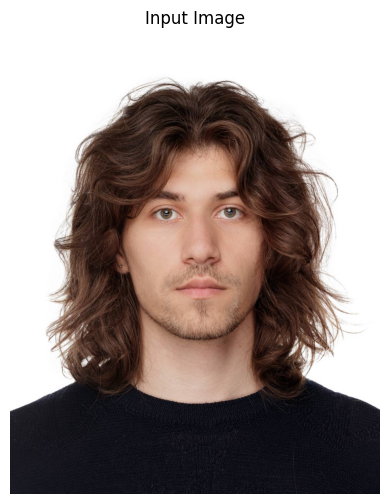

In [8]:
from matplotlib import pyplot as plt
import cv2

test_image_path = "../assets/examples/max.jpg"
test_image = cv2.imread(test_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(test_image[:, :, ::-1])
plt.axis("off")
plt.title("Input Image")
plt.show()

In [12]:
test_embedding = reconstructor.image2embedding(test_image)
print(type(test_embedding), test_embedding.dtype, test_embedding.shape, test_embedding.device)

<class 'torch.Tensor'> torch.float16 torch.Size([1, 77, 768]) cuda:0


  0%|          | 0/25 [00:00<?, ?it/s]

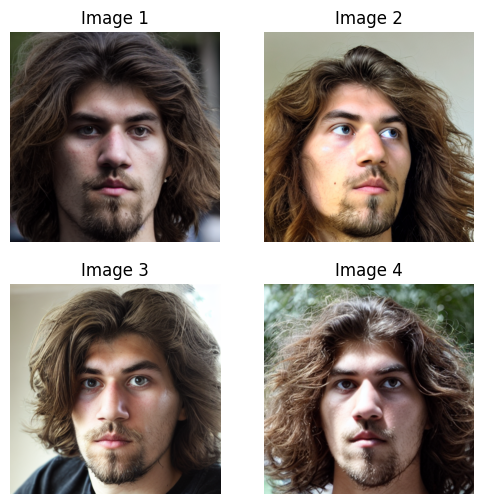

In [3]:
images = reconstructor.generate_images_by_embedding(test_embedding, num_images=4)

plt.subplots(2, 2, figsize=(6, 6))
for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"Image {i + 1}")
plt.show()

In [5]:
from app.metric import Similarity

from insightface.app import FaceAnalysis

model = FaceAnalysis(name="buffalo_l", root="..", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
model.prepare(ctx_id=0, det_size=(640, 640))

metric = Similarity(model=model)
metric.get_embedding(images[1]).shape

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


(512,)

In [6]:
mean_metric_value = 0
count = 0
for i in range(len(images)):
    try:
        metric_value = metric(images[i], test_image)
        mean_metric_value += metric_value
        count += 1

        print(f"Compare image {i + 1} and input image: {metric_value}")
    except Exception as e:
        print(e)
print(mean_metric_value / count)

list index out of range
Compare image 2 and input image: 0.7470648288726807
Compare image 3 and input image: 0.7427736520767212
Compare image 4 and input image: 0.7041043043136597
0.73131424


In [ ]:
# compare true faces
max1 = cv2.imread("../assets/examples/max.jpg")
max2 = cv2.imread("../assets/examples/max2.jpg")
max3 = cv2.imread("../assets/examples/max3.jpg")
max4 = cv2.imread("../assets/examples/max4.jpg")
max1 = cv2.cvtColor(max1, cv2.COLOR_BGR2RGB)
max2 = cv2.cvtColor(max2, cv2.COLOR_BGR2RGB)
max3 = cv2.cvtColor(max3, cv2.COLOR_BGR2RGB)
max4 = cv2.cvtColor(max4, cv2.COLOR_BGR2RGB)

plt.subplots(2, 2, figsize=(6, 6))
for i in enumerate([max1, max2, max3, max4]):
    plt.subplot(2, 2, i[0] + 1)
    plt.imshow(i[1])
    plt.axis("off")
    plt.title(f"Image {i[0] + 1}")
plt.show()

metrics = [
    metric(max1, max2),
    metric(max1, max3),
    metric(max1, max4),
    metric(max2, max3),
    metric(max2, max4),
    metric(max3, max4),
]

print(f"Compare max1 and max2: {metrics[0]}")
print(f"Compare max1 and max3: {metrics[1]}")
print(f"Compare max1 and max4: {metrics[2]}")
print(f"Compare max2 and max3: {metrics[3]}")
print(f"Compare max2 and max4: {metrics[4]}")
print(f"Compare max3 and max4: {metrics[5]}")

print(f"Mean metric value: {sum(metrics) / len(metrics)}")